In [1]:
import numpy as np 
import pandas as pd 

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# Import models
from surprise import (SVD,
                      SVDpp,
                      SlopeOne,
                      NMF,
                      NormalPredictor,
                      KNNBaseline,
                      KNNWithMeans,
                      KNNWithZScore,
                      BaselineOnly,
                      CoClustering,)

from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

In [9]:
def load_data(name):
    return pd.read_csv('data/' + name)


def take_samples(df, n_samples:int, size:int, random_state=None):
    """Takes samples from DataFrame object returns a dictionary with samples
    
    Args:
        df -> pd.DataFrame: Data in which to take samples from
        n_samples -> int: Number of samples
        size -> int: Number of observations per sample
        random_state -> int: For reproducible results
        
    Returns:
        Dictionary of samples where keys (zero indexed) are the samples and values are the samples observations
        
    Examples:
        # From DataFrame 'df' take 5 samples each containing 100 observations
        samples = takes_samples(df=df, 
                                n_samples=5, 
                                size=100)
                                
        samples.get(0)  # Get first sample containing 100 observations
        samples.get(1)  # Get next sample containing 100 observations etc...
    """
    df = df.copy()
    df_size = df.shape[0]
    
    n_samples = range(0, n_samples)
    n_samples_length = len(n_samples)

    required_size = n_samples_length * size
    if required_size > df_size:
        raise ValueError(f'Dataframe of size {df_size} is not big enough to support '
                         f'required size of {required_size}')
        
    sample_dict = {}
    for i in tqdm(n_samples):
        sample = df.sample(size, random_state=random_state)
        sample_dict[i] = sample
        df.drop(sample.index, inplace=True)
    return sample_dict

In [10]:
train_df = load_data('train.csv')
test_df = load_data('test.csv')

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


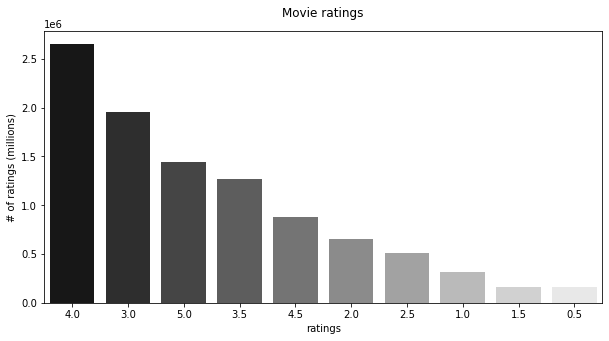

In [12]:
fig, ax = plt.subplots(figsize=(10,5))


ratings_plot = sns.countplot(x='rating', 
                            data=train_df, 
                            order=train_df.rating.value_counts().index,
                            palette='binary_r',
                            ax=ax)

ratings_plot.set_title('Movie ratings', y=1.03)
ratings_plot.set_xlabel('ratings')
ratings_plot.set_ylabel('# of ratings (millions)')

plt.show()

### train.csv breakdown
---

- shape = (10000038, 4)
- memory_usage = 305.2 mb
- Ratings on average are positive

In [13]:
sample = take_samples(train_df, 1, 20000, random_state=22).get(0)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


### Testing mutliple algorithms on sampled data:
---

In [14]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(sample[['userId', 'movieId', 'rating']], reader)


algorithms = [SVD(), SVDpp(), SlopeOne(), 
              NMF(), NormalPredictor(), KNNBaseline(), 
              KNNWithMeans(), KNNWithZScore(), BaselineOnly(),
              CoClustering(),]

benchmark = {}
for algorithm in algorithms:   
    results = cross_validate(algorithm, 
                             data, 
                             measures=['RMSE'], 
                             cv=3,)
    
    algorithm_name = str(algorithm).split('.')[-1].split(' ')[0]
    benchmark[algorithm_name] = pd.DataFrame.from_dict(results).mean()

benchmark_df = pd.DataFrame(benchmark)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [15]:
# Sort table by test_rmse
order_best_rmse = benchmark_df.loc['test_rmse'].sort_values().index
benchmark_df = benchmark_df[order_best_rmse]

benchmark_df

,SVDpp,SVD,BaselineOnly,KNNBaseline,KNNWithZScore,SlopeOne,KNNWithMeans,NMF,CoClustering,NormalPredictor
test_rmse,1.016377,1.020313,1.021385,1.023272,1.101339,1.103869,1.107318,1.107383,1.124783,1.454864
fit_time,1.090058,0.783953,0.050699,2.465656,2.884790,0.363158,2.545549,1.497300,1.130372,0.015493
test_time,0.043024,0.036106,0.023406,0.039440,0.040009,0.069825,0.037379,0.032121,0.023834,0.039307


### Model selection
---

- BaselineOnly has a good test_rmse with a low time cost

In [16]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()

In [17]:
algorithm = BaselineOnly()
algorithm.fit(trainset)

Estimating biases using als...


In [32]:
submission = test_df.copy()
zip_user_movie = list(zip(submission.userId, submission.movieId))


# Concat userId_movieId
submission['id'] = [str(user) + '_' + str(movie) 
                    for user, movie 
                    in zip_user_movie]


# Get predicted ratings for each user + movie 
submission['rating'] = [algorithm.predict(user, 
                                          movie).est 
                        for user, movie 
                        in zip_user_movie]

# Round rating predictions
submission['rating'] = [round((r*2),0)/2 for r in submission.rating]

# Drop userId and movieId features
submission.drop(['userId', 'movieId'], axis=1, inplace=True)

In [33]:
submission.to_csv('submission/submission_v01.csv', index=False)